In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import permutation_test_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sn
from sklearn import metrics
import random

In [3]:
import sys
sys.path.append('../')
import dataimport.prepareDataset as prep

In [4]:
random.seed(141)

are there features which don't have any further content/ don't change over the whole periode


In [5]:
Part_chro=['13','22','10', '18']
Part_reco=['19','20','02','09']



In [6]:

[X,Y_out,Y_ID]=prep.prepare_Contrast_Dataset('data/contrast_NEW_wPLI_all_10_1_left.pickle')

define 30% test set 
!!!! only used to select the hyperparameters 

In [7]:
#X_train,X_test,Y_train,Y_test=train_test_split(X,Y_out,Y_ID,random_state=0,test_size=0.3)
X_train,X_test,Y_train,Y_test,Y_ID_train,Y_ID_test=train_test_split(X,Y_out,Y_ID,random_state=0,test_size=0.3)


LOGISTIC REGRESSION
  I Hyperparameter search

In [8]:
lr=LogisticRegression(random_state=0,penalty='l1',C=4,solver='liblinear',max_iter=10000)

score, permutation_scores, pvalue = permutation_test_score(
    lr, X,Y_out, scoring="accuracy", n_permutations=100, n_jobs=-1,cv=2)


/Users/biapt/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [9]:
# View histogram of permutation scores
plt.hist(permutation_scores, 20, label='Permutation scores Baseline')
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / 2], ylim, '--k', linewidth=3, label='Luck')
plt.legend()
plt.xlabel('Score')

plt.savefig('contrast_wPLI_LogReg_permutation.png',dpi=150)

In [10]:
cs=np.arange(1,4,0.5)
lr_accuracy=[]

for c in cs:
    lr=LogisticRegression(random_state=0,penalty='l1',C=c,solver='liblinear',max_iter=10000)
    lr.fit(X_train,Y_train)
    P_lr=lr.predict(X_test)
    lr_accuracy.append(metrics.accuracy_score(Y_test, P_lr))

In [11]:
np.mean(lr_accuracy)

0.8283333754772801

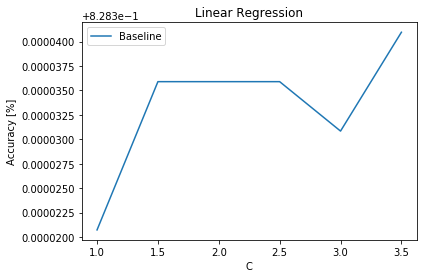

In [12]:
%matplotlib inline

plt.plot(cs,lr_accuracy)
plt.ylabel('Accuracy [%]')
plt.xlabel('C')
plt.title('Linear Regression')
plt.legend(['Baseline','Anesthesia','Recovery'])
plt.savefig('contrast_wpli_LogReg_hyper.png',dpi=150)
plt.show()



In [13]:
from sklearn.linear_model import LogisticRegression


cv_LR=[]
FI_LR=[]

for r in range(0,4):
    for c in range (0,4):
        tmp_X_test=X[(Y_ID == Part_reco[r]) | (Y_ID == Part_chro[c])]
        tmp_X_train=X[(Y_ID != Part_reco[r]) & (Y_ID != Part_chro[c])]
        tmp_Y_test=Y_out[(Y_ID == Part_reco[r]) | (Y_ID == Part_chro[c])]
        tmp_Y_train=Y_out[(Y_ID != Part_reco[r]) & (Y_ID != Part_chro[c])]
        
        lr = LogisticRegression(random_state=0, penalty='l1', C=4,max_iter=1000,solver='liblinear')
        lr.fit(tmp_X_train, tmp_Y_train)
        P_lr = lr.predict(tmp_X_test)
        cv_LR.append(metrics.accuracy_score(tmp_Y_test, P_lr))
        FI_LR.append(lr.coef_)

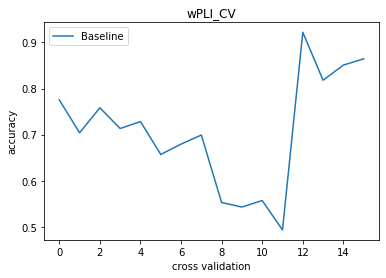

In [14]:

plt.plot(cv_LR)
plt.legend(['Baseline','Anesthesia','Recovery'])
plt.xlabel('cross validation')
plt.ylabel('accuracy')
plt.title('wPLI_CV')
plt.savefig('contrast_wPLI_LogRefg_CV.png',dpi=150)

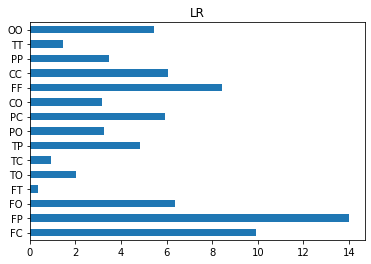

In [15]:
right = np.where(np.array(cv_LR) > 0.5)[0]

FI_LR= list(FI_LR[i] for i in right)

feat_importances_LR = pd.Series(abs(np.mean(FI_LR[0:],axis=0)[0]), index=X.columns)

plt.plot
feat_importances_LR.plot(kind='barh')
plt.title('LR')

plt.savefig('contrast_wPLI_LogReg_features.png',dpi=150)

In [16]:
np.mean(cv_LR)
np.std(cv_LR)

0.12101435168471678

SVM (sklearn)


In [17]:
cs=np.arange(0.3,6,0.2)

svm_accuracy=[]
svm_accuracy_Anes=[]
svm_accuracy_Reco=[]

for c in cs:
    svm_model = svm.LinearSVC(C=c, loss="hinge" , max_iter=100000)
    svm_model.fit(X_train,Y_train)
    P_lr=svm_model.predict(X_test)
    svm_accuracy.append(metrics.accuracy_score(Y_test, P_lr))

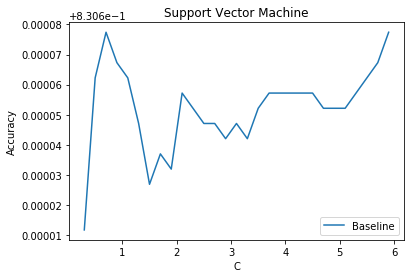

<Figure size 432x288 with 0 Axes>

In [18]:

plt.plot(cs,svm_accuracy)
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.title('Support Vector Machine')
plt.legend(['Baseline','Anesthesia','Recovery'])
plt.show()
plt.savefig('contrast_wPLI_SVM_hyper.png',dpi=150)

In [19]:
cv_SVM=[]

FI_SVM=[]


for r in range(0,4):
    for c in range (0,4):
        tmp_X_test=X[(Y_ID == Part_reco[r]) | (Y_ID == Part_chro[c])]
        tmp_X_train=X[(Y_ID != Part_reco[r]) & (Y_ID != Part_chro[c])]
        tmp_Y_test=Y_out[(Y_ID == Part_reco[r]) | (Y_ID == Part_chro[c])]
        tmp_Y_train=Y_out[(Y_ID != Part_reco[r]) & (Y_ID != Part_chro[c])]
        
        svm_model = svm.LinearSVC(C=4, loss="hinge", max_iter=1000000)
        svm_model.fit(tmp_X_train, tmp_Y_train)
        P_lr = svm_model.predict(tmp_X_test)
        cv_SVM.append(metrics.accuracy_score(tmp_Y_test, P_lr))
        FI_SVM.append(svm_model.coef_.flatten())

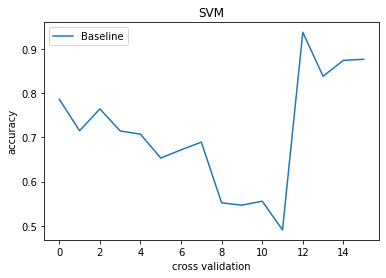

In [20]:
plt.plot(cv_SVM)
plt.legend(['Baseline','Anesthesia','Recovery'])
plt.xlabel('cross validation')
plt.ylabel('accuracy')
plt.title('SVM')
plt.savefig('contrast_wPLI_SVM_CV.png',dpi=150)

In [21]:
np.mean(cv_SVM)

0.7110903032516525

In [22]:
np.std(cv_SVM)


0.12777604700572737

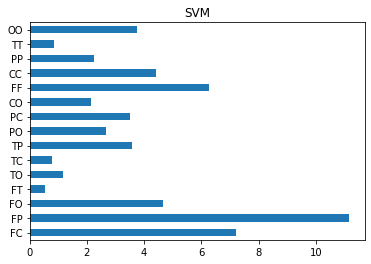

In [23]:
right = np.where(np.array(cv_SVM) > 0.5)[0]

FI_SVM=pd.DataFrame(FI_SVM)

feat_importances_SVM_b = pd.Series(np.array(abs(np.mean(FI_SVM.iloc[right,:],axis=0))), index=X.columns)

feat_importances_SVM = pd.Series(np.array((np.mean(FI_SVM.iloc[right,:],axis=0))), index=X.columns)

plt.plot()
feat_importances_SVM_b.plot(kind='barh')
plt.title('SVM')

plt.savefig('contrast_wPLI_SVM_features.png',dpi=150)
#plt.subplot(133)
#feat_importances_Reco_SVM_b.plot(kind='barh',color='green')
#plt.title('Recovery')


Decision Tree

In [24]:
from sklearn import tree
import graphviz

#clf = tree.DecisionTreeClassifier(criterion='entropy')
#clf = clf.fit(X,Y_out)
#dot_data = tree.export_graphviz(clf, out_file=None, feature_names=X.columns, class_names=['Chronic', 'recovered'],
#                                filled=True, rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data)
#graph.render('contrast_wPLI_Decision_Tree')





In [25]:
data = [[np.max(lr_accuracy), np.max(svm_accuracy)], 
        [np.mean(cv_LR), np.mean(cv_SVM)]]

pd.DataFrame(data, columns=["Logistic Regression", "SVM"],index=['30% Test','Cross Validation'])

,Logistic Regression,SVM
30% Test,0.828341,0.830677
Cross Validation,0.707184,0.711090
